# Intraday_price_pattern matching

국채선물 10년물의 전일자 일중 가격변화 패턴을 바탕으로 과거의 패턴과 비교하여,
가장 유사도가 높은 n개의 일자들의 다음날 가격변화를 차트로 보여주는 예제입니다.


2011년~2019년의 국채선물 10년물 1분단위 데이터를 기반으로 n분단위로 resample해서 비교합니다.

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

In [2]:
# 10년 국채선물 1분단위 데이터를 불러옵니다.
df = pd.read_csv("LKTB_infomax_1m_20200521.csv")
df

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOLUME,OPENINTEREST
0,2011-01-03,10:01:00,103.29,103.29,103.27,103.27,20,2047
1,2011-01-03,10:02:00,103.27,103.27,103.27,103.27,0,2047
2,2011-01-03,10:03:00,103.06,103.06,103.04,103.04,20,2057
3,2011-01-03,10:04:00,103.06,103.06,103.06,103.06,5,2062
4,2011-01-03,10:05:00,103.06,103.06,103.06,103.06,0,2062
...,...,...,...,...,...,...,...,...
893605,2020-05-21,15:41:00,134.13,134.13,134.13,134.13,0,140360
893606,2020-05-21,15:42:00,134.13,134.13,134.13,134.13,0,140360
893607,2020-05-21,15:43:00,134.13,134.13,134.13,134.13,0,140360
893608,2020-05-21,15:44:00,134.13,134.13,134.13,134.13,0,140360


In [3]:
# 분리되어 있는 날짜(DATE)와 시간(TIME)열을 합치는 작업
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
df = df.drop(['DATE', 'TIME'], axis=1)
df = df.set_index('DATETIME')
df

,OPEN,HIGH,LOW,CLOSE,VOLUME,OPENINTEREST
DATETIME,,,,,,
2011-01-03 10:01:00,103.29,103.29,103.27,103.27,20,2047
2011-01-03 10:02:00,103.27,103.27,103.27,103.27,0,2047
2011-01-03 10:03:00,103.06,103.06,103.04,103.04,20,2057
2011-01-03 10:04:00,103.06,103.06,103.06,103.06,5,2062
2011-01-03 10:05:00,103.06,103.06,103.06,103.06,0,2062
...,...,...,...,...,...,...
2020-05-21 15:41:00,134.13,134.13,134.13,134.13,0,140360
2020-05-21 15:42:00,134.13,134.13,134.13,134.13,0,140360
2020-05-21 15:43:00,134.13,134.13,134.13,134.13,0,140360


In [4]:
# 주요 변수 세팅
daycount_match = 2 # 매칭할 대상 기간 : 이틀치를 가지고 비교합니다.
daycount_forecast = 1 # 전망할 날짜 수 :  다음날 하루의 패턴을 보여줍니다.
resample_minutes = 10 # 가격주기 : 10분 단위 데이터를 기반으로 합니다.

In [5]:
# 1분단위로 되어있는 데이터를 resample_minutes(10) 주기로 resample 해준다.
df = df.resample(str(resample_minutes) + 'T', closed='right').agg({
    'OPEN': 'first',
    'HIGH': 'max',
    'LOW': 'min',
    'CLOSE': 'last',
    'VOLUME': 'sum',
    'OPENINTEREST': 'last'
    }).dropna()
df

,OPEN,HIGH,LOW,CLOSE,VOLUME,OPENINTEREST
DATETIME,,,,,,
2011-01-03 10:00:00,103.29,103.29,103.03,103.03,75,2067.0
2011-01-03 10:10:00,103.03,103.06,102.94,103.01,65,2048.0
2011-01-03 10:20:00,103.01,103.01,102.75,102.75,126,2099.0
2011-01-03 10:30:00,102.76,102.89,102.76,102.82,66,2086.0
2011-01-03 10:40:00,102.82,102.89,102.82,102.89,15,2085.0
...,...,...,...,...,...,...
2020-05-21 15:00:00,134.06,134.10,133.97,134.00,2065,140475.0
2020-05-21 15:10:00,134.01,134.10,134.01,134.07,2423,140506.0
2020-05-21 15:20:00,134.06,134.13,134.04,134.13,1554,140352.0


In [6]:
# 날짜의 목록을 만들어준다.
list_day = df.resample('D') \
    .last() \
        .dropna() \
            .drop(['OPEN', 'HIGH', 'LOW', 'VOLUME','OPENINTEREST'], axis=1) \
                .reset_index()['DATETIME'] \
                    .dt.date \
                        .to_numpy().tolist()
print(len(list_day), list_day[-1])

2310 2020-05-21


In [7]:
# 매칭할 날짜 설정
x_end_date = list_day[-1] # data중 마지막 날짜로 세팅하는 경우

# %% 날짜 list에서 패턴 매칭대상 start_date, end_date 가져오기
x_start_date = list_day[(list_day.index(x_end_date) - daycount_match + 1)]

print(x_start_date, x_end_date)

2020-05-20 2020-05-21


In [8]:
# 패턴매칭해볼 대상인 기간의 dataframe
df_x = df.loc[x_start_date.isoformat():x_end_date.isoformat()]
df_x

,OPEN,HIGH,LOW,CLOSE,VOLUME,OPENINTEREST
DATETIME,,,,,,
2020-05-20 09:00:00,133.70,133.71,133.59,133.63,3069,137815.0
2020-05-20 09:10:00,133.63,133.63,133.54,133.56,1979,138119.0
2020-05-20 09:20:00,133.57,133.60,133.57,133.58,722,138158.0
2020-05-20 09:30:00,133.58,133.63,133.58,133.60,1369,138212.0
2020-05-20 09:40:00,133.61,133.62,133.58,133.62,563,138260.0
...,...,...,...,...,...,...
2020-05-21 15:00:00,134.06,134.10,133.97,134.00,2065,140475.0
2020-05-21 15:10:00,134.01,134.10,134.01,134.07,2423,140506.0
2020-05-21 15:20:00,134.06,134.13,134.04,134.13,1554,140352.0


In [9]:
# 패턴매칭대상 가격 moves 만들기
np_moves_target = df_x['CLOSE'].to_numpy()

np_moves_target

array([133.63, 133.56, 133.58, 133.6 , 133.62, 133.66, 133.74, 133.75,
       133.81, 133.86, 133.89, 133.83, 133.88, 133.86, 133.86, 133.88,
       133.84, 133.87, 133.84, 133.82, 133.79, 133.82, 133.83, 133.88,
       133.86, 133.88, 133.92, 133.92, 133.94, 133.99, 133.97, 133.9 ,
       133.93, 133.89, 133.86, 133.86, 133.91, 133.87, 133.94, 133.87,
       133.87, 133.98, 133.95, 133.97, 133.91, 133.89, 133.77, 133.77,
       133.73, 133.71, 133.72, 133.75, 133.81, 133.86, 133.86, 133.86,
       133.85, 133.84, 133.86, 133.87, 133.86, 133.88, 133.9 , 133.93,
       133.93, 133.95, 133.98, 133.97, 133.98, 133.99, 133.96, 133.97,
       133.95, 134.04, 134.05, 134.05, 134.06, 134.  , 134.07, 134.13,
       134.13, 134.11])

In [10]:
# 가져온 moves 를 z 표준화
np_moves_target_z = stats.zscore(np_moves_target)
np_moves_target_z

array([-2.11829938, -2.71815327, -2.54676645, -2.37537962, -2.20399279,
       -1.86121914, -1.17567183, -1.08997842, -0.57581794, -0.14735087,
        0.10972937, -0.40443111,  0.02403596, -0.14735087, -0.14735087,
        0.02403596, -0.3187377 , -0.06165746, -0.3187377 , -0.49012452,
       -0.74720476, -0.49012452, -0.40443111,  0.02403596, -0.14735087,
        0.02403596,  0.36680961,  0.36680961,  0.53819644,  0.96666351,
        0.79527668,  0.19542278,  0.45250302,  0.10972937, -0.14735087,
       -0.14735087,  0.2811162 , -0.06165746,  0.53819644, -0.06165746,
       -0.06165746,  0.88097009,  0.62388985,  0.79527668,  0.2811162 ,
        0.10972937, -0.91859159, -0.91859159, -1.26136524, -1.43275207,
       -1.34705866, -1.08997842, -0.57581794, -0.14735087, -0.14735087,
       -0.14735087, -0.23304428, -0.3187377 , -0.14735087, -0.06165746,
       -0.14735087,  0.02403596,  0.19542278,  0.45250302,  0.45250302,
        0.62388985,  0.88097009,  0.79527668,  0.88097009,  0.96

In [11]:
# 매칭할 전체 가격 moves의 개수
len(np_moves_target_z)

82

In [12]:
# %% 기준일과 매칭할 날짜 수 setting
daycount_match = 2 # 매칭할 대상 기간 : 2 days
daycount_forecast = 1 # 전망할 날짜 수 :  1 day
resample_minutes = 10 # 가격주기 : 10 mins

date_split = '2019-01-01'

In [13]:
# df를 이틀치씩(daycount_match)으로 분리하기위한 날짜 목록(시작일,종료일) list를 만든다.
list_start_date = []
list_end_date = []

for i in range(len(list_day)-daycount_match + 1):
    if list_day[i + daycount_match - 1] < x_end_date: #자기 자신 패턴을 피하기 위해
        list_start_date.append(list_day[i])
        list_end_date.append(list_day[i + daycount_match - 1])

In [14]:
print(list_start_date[-1], list_end_date[-1])

2020-05-19 2020-05-20


In [15]:
# 위의 날짜목록에 해당하는 가격변화(moves)를 분리해낸다.
list_moves = []
for i in range(len(list_start_date)):
# for i in range(10):
    list_moves.append(df.loc[list_start_date[i].isoformat():list_end_date[i].isoformat()]['CLOSE'].to_numpy())

print(len(list_moves))


2308


In [16]:
# DTW(Dynamic Time Warping) 두개의 시계열 데이터간의 유사도를 계산하는 DTW 알고리즘을 사용
list_dtw = []

from dtw import accelerated_dtw
from tqdm import tqdm

# 대상패턴과 각 가격변화들의 dtw거리를 산출하여 list_dtw 리스트를 만든다.
for np_moves_data in tqdm(list_moves):
    d, _, _, _ = accelerated_dtw(np_moves_target_z, stats.zscore(np_moves_data), 'euclidean')
    list_dtw.append(d)

100%|██████████| 2308/2308 [00:25<00:00, 90.40it/s]


In [17]:
for i in range(10):
    print(list_dtw[i])

85.50924136378525
72.21482999946596
99.78607486034807
85.83509491100081
72.05167786966558
59.470341638278036
41.82909410921973
67.39595020643414
54.181846838912705
26.328503686578156


In [18]:
# dtw값이 적은 순서대로 순위 매기기(stats.rankdata)
list_rank = stats.rankdata(list_dtw).tolist()

for i in range(10):
    print(list_rank[i])

1909.0
1636.0
2155.0
1917.0
1630.0
1352.0
726.0
1530.0
1192.0
61.0


In [19]:
# 기간, dtw거리, 순위가 모두 포함된 결과 dataframe 만들기
df_result = pd.DataFrame(list(zip(list_start_date, list_end_date, list_dtw, list_rank)),
                         columns = ['start', 'end', 'dtw', 'rank'])
df_result

,start,end,dtw,rank
0,2011-01-03,2011-01-04,85.509241,1909.0
1,2011-01-04,2011-01-05,72.214830,1636.0
2,2011-01-05,2011-01-06,99.786075,2155.0
3,2011-01-06,2011-01-07,85.835095,1917.0
4,2011-01-07,2011-01-10,72.051678,1630.0
...,...,...,...,...
2303,2020-05-13,2020-05-14,35.979012,380.0
2304,2020-05-14,2020-05-15,65.710613,1496.0
2305,2020-05-15,2020-05-18,45.801310,905.0
2306,2020-05-18,2020-05-19,41.401534,705.0


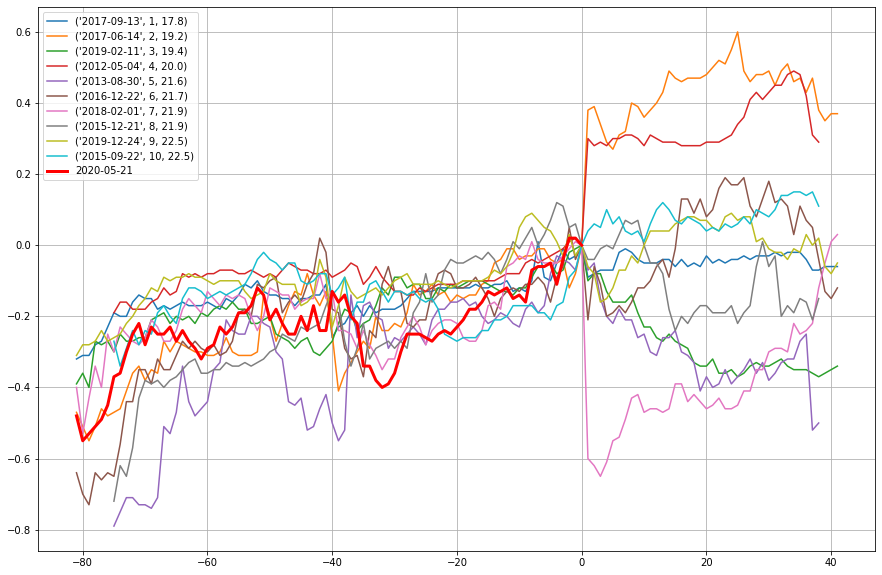

In [20]:
# rank가 낮은것(유사도가 높은것)부터 순서대로 10(max_rank)개 차트를 그립니다.
max_rank = 10

f1 = plt.figure(figsize=(15, 10))
plt.grid(b=True)

# 하루중 장 시간이 달랐던 적이 있어서(장 30분 연장, 1월2일 등) 맞춰주기 위한 조정
minutes_per_day = 405 
points_per_day = math.ceil(minutes_per_day / resample_minutes)
points_before = points_per_day * daycount_match
points_after = points_per_day * daycount_forecast

x = np.linspace(-points_before + 1,points_after, points_before + points_after )

for rank in range(1,max_rank+1):
    index = list_rank.index(rank)
    dtw = list_dtw[index]
    moves_before = df.loc[list_start_date[index].isoformat():list_end_date[index].isoformat()]['CLOSE'].to_numpy()
    moves_after = df.loc[list_day[list_day.index(list_end_date[index]) + 1].isoformat():
                         list_day[min(list_day.index(list_end_date[index]) + daycount_forecast, len(list_day) - 1)].isoformat()]['CLOSE'].to_numpy()
    pivot_price = moves_before[-1]
    moves_before_scaled = moves_before - pivot_price
    moves_after_scaled = moves_after - pivot_price
    moves = np.concatenate((
        [np.nan]*(points_before - len(moves_before_scaled)),
        moves_before_scaled,
        moves_after_scaled,
        [np.nan]*(points_after - len(moves_after_scaled))
        ))
    plt.plot(x,moves,  label=(list_end_date[index].isoformat(),rank, round(dtw,1)))

# %%

# target moves plotting
pivot_price_target = np_moves_target[-1]
moves_target_before_scaled = np_moves_target - pivot_price_target
moves_target_after_scaled = []
moves_target_scaled = np.concatenate((
    [np.nan]*(points_before-len(moves_target_before_scaled)),
    moves_target_before_scaled,
    moves_target_after_scaled,
    [np.nan]*(points_after-len(moves_target_after_scaled))
    ))

plt.plot(x, moves_target_scaled,'r-', label=x_end_date, linewidth=3.0)
plt.legend(loc='best')
plt.show()

유사도가 높은 것부터 일자, 순위, dtw거리 를 나타냅니다.